# Clustering using auto-encoding neural networks and classical k-means

The objective is to identify structures in the overall client population in order to help the human operator distinct between possible frauds and legit transactions. When the client plays with a sum that surpasses a certain treshold, the transaction is tempararily blocked, pending for supervision. The algorithm will help either by classifying the client in a known cluster or recognizing it as an anomaly in the overall dataset, the human operator can then decide if blocking the transaction completely or letting it through.

In order to achieve the objective, the algorithm will be composed of multiple elements: the raw data has high feature cardinality and comprises millions of data-points, so in order to reduce the dimensinality for better and faster analisys, we will implement the encoder part of an auto-encoder neural network (trained on the whole dataset) for automatic PCA, and then the features extracted this way will be fed into a k-means clustering algorithm to segment the client data into subgroups.

The data was taken from a software developement company and in this case is comprised of user interaction data on various betting websites. 

FOR FRAUD DETECTION I NEED THE DATA FOR SINGLE TRANSACTIONS, THE DATA HERE IS GROUPED BY CLIENT AND THIS IS A CLIENT CLUSTERING ALGORITHM

#### Autoencoder
Implemented early stopping to cut training if a loss minimum is reached.

First testing excluded SDG as optimizer in favor of Adam, still searching through neuron layers and numbers parameter space.

Four layers [500-10] underfittig, loss too high cant recreate istance precisely.

Five layers [1000-10], learning rate too big: loss diverges.

Five layers [1000-500-250-100-10], batch size 500, learning rate [1.0e-07]. Can't discerne between clusters, all classes assigned are 0.

Changed normalization regularization from l1 to l2, added Dropout layers with 0.5 rate

Six Layers [1000-500-500-250-100-10], learning rate [0.00001], added history check. Improvement in cluster analysis, most classes predicted are 0 but there are exceptions (4s and 7s).



# Imports

In [2]:
import numpy as np
np.random.seed(10)

In [3]:
from time import time
import keras.backend as K
import pandas as pd
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras import metrics
from sklearn.preprocessing import Imputer
from os import path

Using TensorFlow backend.
/home/alex/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/.local/lib/python3.7/site-packages/tensorflow/python/framewo

# Autoencoder structure

In [4]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)
        x = Dropout(0.5, seed=42)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='bottleneck')(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)
        x = Dropout(0.5, seed=42)(x)
        
    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

# Load Dataset

In [5]:
cols = pd.read_csv("Header.csv")
cols = cols.columns.values

In [6]:
x_raw = pd.read_csv("DataExport.csv")
x_raw.columns=cols
x_raw.set_index("ID", inplace=True)
x_raw.sort_values(by="ID").head()

,NUM,SUMImporto,MAXImporto,MINImporto,SUMVincita,SUMVincitaPotenziale,Periodo,AVGImporto,AVGVincita,AVGVincitaPotenziale,...,AVGEsitoDSPerdente,AVGEsitoDSAnnullato,AVGEsitoDSVincente,AVGEsitoDSVincenteQ1,AVGEsitoDSMetaVincente,AVGEsitoDSMetaPerdente,AVGEventiDistinti,MAXEventiDistinti,MINEventiDistinti,STDEVEventiDistinti
ID,,,,,,,,,,,,,,,,,,,,,
12679,395,69410.0,2500.0,100.0,102129.4971,3.181365e+08,30,175.721518,258.555688,805408.950729,...,0.448101,0.002531,1.134177,0.0,0.0,0.0,7.518987,28.0,1.0,4.905350
12683,109,28100.0,2500.0,100.0,10821.8360,2.917482e+07,34,257.798165,99.282899,267658.937617,...,0.513761,0.018348,1.201834,0.0,0.0,0.0,5.917431,24.0,1.0,4.696587
12684,196,31900.0,1000.0,100.0,6352.1609,6.327533e+07,30,162.755102,32.408984,322833.320556,...,0.301020,0.000000,0.658163,0.0,0.0,0.0,6.270408,29.0,1.0,4.842477
12686,15,15000.0,2500.0,500.0,0.0000,9.093243e+05,1,1000.000000,0.000000,60621.616853,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.333333,6.0,1.0,1.345185
12690,24,31400.0,8000.0,100.0,0.0000,9.887282e+06,6,1308.333333,0.000000,411970.063962,...,0.541666,0.000000,1.250000,0.0,0.0,0.0,6.500000,22.0,1.0,5.116045


In [7]:
x_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288329 entries, 1000789 to 99953
Data columns (total 63 columns):
NUM                       288329 non-null int64
SUMImporto                288329 non-null float64
MAXImporto                288329 non-null float64
MINImporto                288329 non-null float64
SUMVincita                288329 non-null float64
SUMVincitaPotenziale      288329 non-null float64
Periodo                   288329 non-null int64
AVGImporto                288329 non-null float64
AVGVincita                288329 non-null float64
AVGVincitaPotenziale      288329 non-null float64
STDEVImporto              288329 non-null float64
STDEVVincita              288329 non-null float64
STDEVVincitaPotenziale    288329 non-null float64
MAXVincita                288329 non-null float64
MINVincita                288329 non-null float64
MAXVincitaPotenziale      288329 non-null float64
MINVincitaPotenziale      288329 non-null float64
EsitoVincente             288329 non-n

# Fill missing values and normalize

In [8]:
from sklearn.impute import SimpleImputer
from keras.utils import normalize
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
x_full=pd.DataFrame(imp_mean.fit_transform(x_raw))
x = normalize(x_full, axis=0, order=2)
#cols=np.delete(cols,[0,0])
#x.columns=cols
#x.set_index("ID", inplace=True)
x.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.001050,0.000248,0.000227,0.000012,0.000000,1.478580e-03,0.001111,0.000060,0.000000,9.667082e-04,...,0.000200,0.000000,0.000051,0.000000,0.0,0.0,0.001308,0.001543,0.000389,0.001601
1,0.000700,0.000101,0.000076,0.000012,0.000085,9.824707e-07,0.003149,0.000037,0.000019,9.635215e-07,...,0.000060,0.000133,0.000785,0.001435,0.0,0.0,0.000631,0.000926,0.000389,0.001056
2,0.000044,0.000037,0.000152,0.000243,0.000000,6.991306e-08,0.000000,0.000217,0.000000,1.097034e-06,...,0.000960,0.000000,0.000000,0.000000,0.0,0.0,0.000273,0.000154,0.000389,0.000000
3,0.000175,0.000012,0.000023,0.000012,0.000000,2.333955e-06,0.002871,0.000018,0.000000,9.155755e-06,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000478,0.000617,0.000389,0.000910
4,0.000219,0.000032,0.000038,0.000024,0.000000,3.371066e-06,0.002223,0.000037,0.000000,1.057935e-05,...,0.000384,0.000000,0.000243,0.000000,0.0,0.0,0.001201,0.001235,0.000389,0.001640


# Split dataset into train and test sets

In [9]:
x_train, x_test = train_test_split(x, test_size=0.25, random_state=42)

# Hyperparameters

In [10]:
dims = [x_train.shape[-1], 750, 500, 250, 75, 3]
#Xavier init
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
pretrain_epochs = 3000
batch_size = 500
save_dir = './results'

# Create actual NN

In [11]:
autoencoder, encoder = autoencoder(dims, init=init)

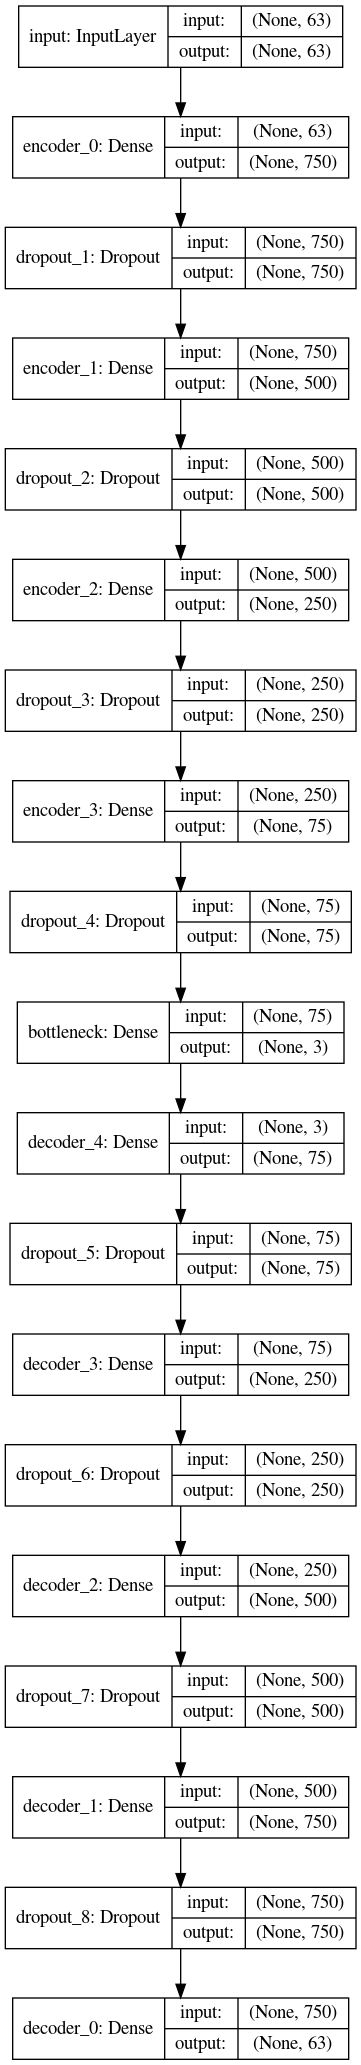

In [12]:
#Show general structure Auto-Encoder
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

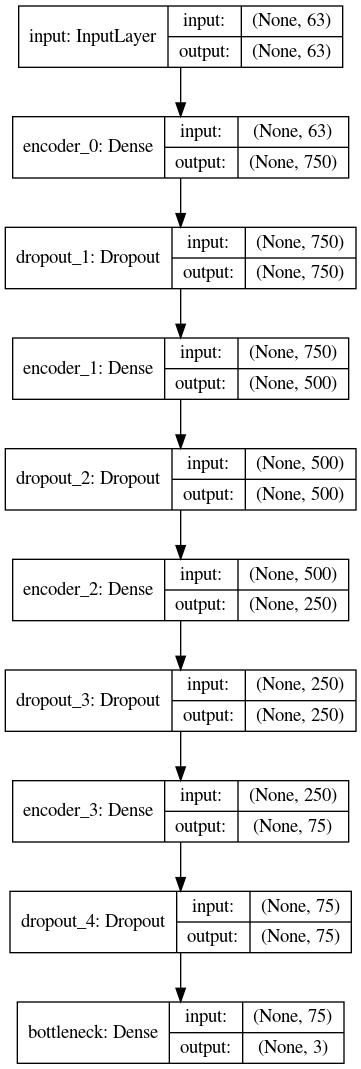

In [13]:
#Show general structure of Encoder
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')

# Pre-train Auto-Encoder

In [13]:
#Set callback to save weights each epoch
checkpoint = ModelCheckpoint(filepath=save_dir + '/ae_weights_temp.h5', monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
#Set callback for early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)

#load partial training weights
#if path.exists(save_dir + '/ae_weights_temp.h5'):
#    autoencoder.load_weights(save_dir + '/ae_weights_temp.h5')

autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
history = autoencoder.fit(x_train, x_train,
                          validation_split=0.25,
                          batch_size=batch_size, 
                          epochs=pretrain_epochs,
                          verbose=1,
                          callbacks=[checkpoint, es])

autoencoder.save_weights(save_dir + '/ae_weights.h5')


Train on 162184 samples, validate on 54062 samples
Epoch 1/3000
162184/162184 [==============================] - 13s 82us/step - loss: 2.7974e-06 - val_loss: 3.5527e-06

Epoch 00001: loss improved from inf to 0.00000, saving model to ./results/ae_weights_temp.h5
Epoch 2/3000
162184/162184 [==============================] - 14s 89us/step - loss: 2.7885e-06 - val_loss: 3.5598e-06

Epoch 00002: loss improved from 0.00000 to 0.00000, saving model to ./results/ae_weights_temp.h5
Epoch 3/3000
162184/162184 [==============================] - 17s 105us/step - loss: 2.7893e-06 - val_loss: 3.5527e-06

Epoch 00003: loss did not improve from 0.00000
Epoch 4/3000
162184/162184 [==============================] - 18s 113us/step - loss: 2.7888e-06 - val_loss: 3.5525e-06

Epoch 00004: loss did not improve from 0.00000
Epoch 5/3000
162184/162184 [==============================] - 18s 114us/step - loss: 2.7888e-06 - val_loss: 3.5548e-06

Epoch 00005: loss did not improve from 0.00000
Epoch 6/3000
162184

162184/162184 [==============================] - 19s 118us/step - loss: 2.3409e-06 - val_loss: 3.1197e-06

Epoch 00085: loss did not improve from 0.00000
Epoch 86/3000
162184/162184 [==============================] - 19s 118us/step - loss: 2.2751e-06 - val_loss: 3.1289e-06

Epoch 00086: loss did not improve from 0.00000
Epoch 87/3000
162184/162184 [==============================] - 20s 124us/step - loss: 2.3351e-06 - val_loss: 3.1356e-06

Epoch 00087: loss did not improve from 0.00000
Epoch 88/3000
162184/162184 [==============================] - 19s 117us/step - loss: 2.2620e-06 - val_loss: 3.1834e-06

Epoch 00088: loss improved from 0.00000 to 0.00000, saving model to ./results/ae_weights_temp.h5
Epoch 89/3000
162184/162184 [==============================] - 19s 117us/step - loss: 2.3136e-06 - val_loss: 3.1495e-06

Epoch 00089: loss did not improve from 0.00000
Epoch 90/3000
162184/162184 [==============================] - 19s 118us/step - loss: 2.2849e-06 - val_loss: 3.1068e-06

Epo

162184/162184 [==============================] - 19s 118us/step - loss: 2.1377e-06 - val_loss: 3.0632e-06

Epoch 00178: loss did not improve from 0.00000
Epoch 179/3000
162184/162184 [==============================] - 19s 118us/step - loss: 2.2205e-06 - val_loss: 3.0378e-06

Epoch 00179: loss did not improve from 0.00000
Epoch 180/3000
162184/162184 [==============================] - 20s 121us/step - loss: 2.1028e-06 - val_loss: 3.0168e-06

Epoch 00180: loss did not improve from 0.00000
Epoch 181/3000
162184/162184 [==============================] - 19s 118us/step - loss: 2.1755e-06 - val_loss: 3.0168e-06

Epoch 00181: loss did not improve from 0.00000
Epoch 182/3000
162184/162184 [==============================] - 19s 118us/step - loss: 2.1361e-06 - val_loss: 3.0193e-06

Epoch 00182: loss did not improve from 0.00000
Epoch 183/3000
162184/162184 [==============================] - 20s 122us/step - loss: 2.3445e-06 - val_loss: 3.0609e-06

Epoch 00183: loss did not improve from 0.00000
E

162184/162184 [==============================] - 19s 117us/step - loss: 2.0681e-06 - val_loss: 3.1453e-06

Epoch 00273: loss did not improve from 0.00000
Epoch 274/3000
162184/162184 [==============================] - 20s 122us/step - loss: 2.2404e-06 - val_loss: 3.0842e-06

Epoch 00274: loss did not improve from 0.00000
Epoch 275/3000
162184/162184 [==============================] - 19s 117us/step - loss: 2.1591e-06 - val_loss: 3.1017e-06

Epoch 00275: loss did not improve from 0.00000
Epoch 276/3000
162184/162184 [==============================] - 20s 121us/step - loss: 2.0781e-06 - val_loss: 3.0716e-06

Epoch 00276: loss did not improve from 0.00000
Epoch 277/3000
162184/162184 [==============================] - 19s 119us/step - loss: 2.0971e-06 - val_loss: 3.0944e-06

Epoch 00277: loss did not improve from 0.00000
Epoch 278/3000
162184/162184 [==============================] - 20s 122us/step - loss: 2.1073e-06 - val_loss: 3.0795e-06

Epoch 00278: loss did not improve from 0.00000
E

In [14]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Plot model loss

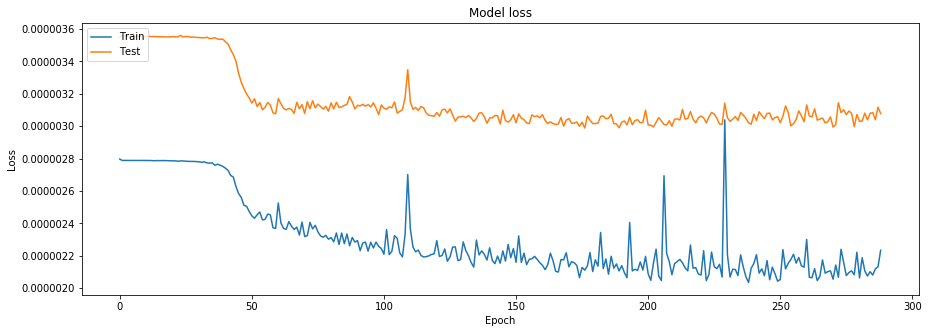

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(15,5)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('train_val_loss.png')
plt.show()

### Test on one instance

In [16]:
#autoencoder.load_weights(save_dir + '/ae_weights.h5')
test_index = 100
test_item = pd.DataFrame(np.array(x_test.iloc[test_index])).T
prediction_ae = autoencoder.predict(test_item)

list=[]
list.append(test_item)
list.append(pd.DataFrame(prediction_ae))
pd.concat(list)

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.000044,0.000009,0.000038,0.000061,0.000000,0.000012,0.000000,0.000054,0.000000,0.000184,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000819,0.000463,0.001168,0.000000
0,0.000008,-0.000025,0.000002,0.000030,-0.000006,-0.000073,0.000692,0.000024,0.000018,0.000028,...,0.00126,0.000201,0.001269,0.000358,-0.000016,0.000021,0.001290,0.000843,0.001503,0.000564


In [17]:
#autoencoder.load_weights(save_dir + '/ae_weights.h5')
test_index = [10,5000]
test_item = pd.DataFrame(np.array(x_train.iloc[test_index]))
prediction_en = encoder.predict(test_item)

prediction_en

array([[ 0.00759476,  0.00286917, -0.00031225],
       [ 0.0076615 ,  0.00237734, -0.00034575]], dtype=float32)

### Load pre-trained weights

In [18]:
if path.exists(save_dir + '/ae_weights.h5'):
    autoencoder.load_weights(save_dir + '/ae_weights.h5')
if autoencoder.get_weights() is not None:
    print("Weights loaded succesfully.")

Weights loaded succesfully.


# Custom clustering layer

In [19]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

        #define weights
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim),
                                        initializer='glorot_uniform',
                                        name="cluster")
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

        #layer logic
    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    #map input to output
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [20]:
#Create clustering model with pretrained weights for the encoer part
n_clusters = 3
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)   #use pretrained layers from encoder
#Check if weights are passed correctly
if all(model.get_weights()[3] == autoencoder.get_weights()[3]):
    print("Weights loaded correctly.")

Weights loaded correctly.


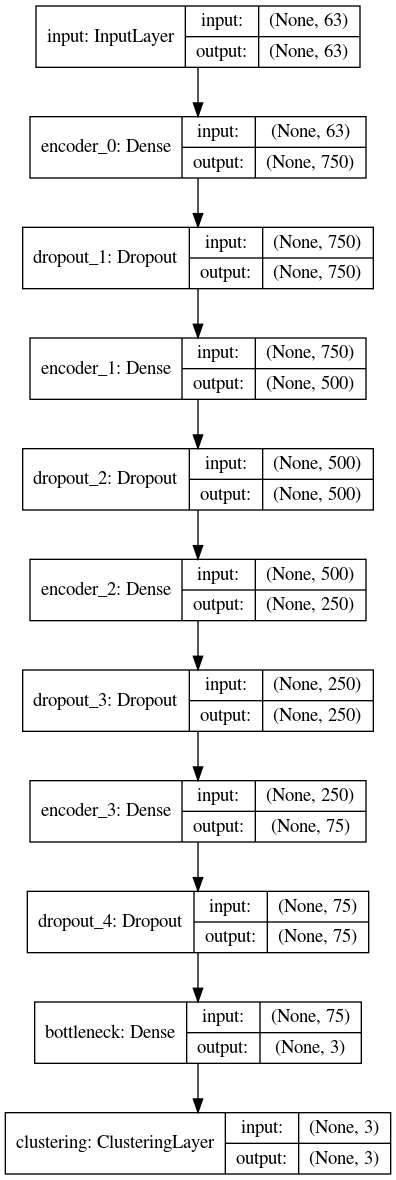

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

# Step 1: Initialize cluster centers with K-means

In [22]:
kmeans = KMeans(n_clusters=n_clusters, 
                n_init=20,  #n of times kmeans is run with different centroid seed, the best one is chosen by inertia
                random_state=42,
                n_jobs=-1,
                verbose=1)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [23]:
y_pred_last = np.copy(y_pred)

clustering_optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
model.compile(optimizer=clustering_optimizer, loss='kld')   #kullback-liebler distribution distance

# Step 2: deep clustering

Compute p_i by first raising q_i (q is the encoded feature tensor) to the second power and then normalizing by frequency per cluster:

In [24]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [25]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])


tol = 0.001 # tolerance threshold to stop training

# Start training

In [26]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=1)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance for labeled data
        #y_pred = q.argmax(1)
        #if y is not None:
            #acc = np.round(metrics.acc(y, y_pred), 5)
            #nmi = np.round(metrics.nmi(y, y_pred), 5)
            #ari = np.round(metrics.ari(y, y_pred), 5)
            #loss = np.round(loss, 5)
            #print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size : min((index+1) * batch_size, x.shape[0])]  #infer range of indexes from batch
    loss = model.train_on_batch(x=x.iloc[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

288329/288329 [==============================] - 11s 38us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
288329/288329 [==============================] - 10s 35us/step
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


In [27]:
q[1], q[100]

(array([0.34028298, 0.34028342, 0.3194336 ], dtype=float32),
 array([0.3403124 , 0.34030998, 0.31937766], dtype=float32))

In [28]:
clustered = []
for pred in q:
    clustered.append(np.argmax(pred))
np.unique(np.array(clustered))

array([0, 1, 2])

In [29]:
prediction_graph = encoder.predict(x)

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xs,ys,zs = zip(*prediction_graph)
c=np.argmax(prediction_graph)
fig = plt.figure(figsize=(20,15))
plt.title("Clustered Clients - K={}".format(n_clusters))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=clustered)
plt.savefig('train_val_loss.png')

/home/alex/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [67]:
clustered_df = pd.DataFrame(clustered)
clustered_df.columns = ["Clusters"]
clustered_df

,Clusters
0,1
1,1
2,0
3,0
4,0
...,...
288324,0
288325,0
288326,0
288327,1


In [71]:
encoded_groupped = pd.DataFrame(np.concatenate((x_raw, clustered_df), axis=1))
#encoded_groupped.columns=cols
encoded_groupped

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,24.0,13300.000,3000.000,100.0,0.0000,6.260057e+07,12.0,554.166666,0.000000,2.608357e+06,...,0.0000,0.1250,0.0000,0.0,0.0,4.791666,10.0,1.0,2.637178,1.0
1,16.0,5400.000,1000.000,100.0,4576.3522,4.159614e+04,34.0,337.500000,286.022012,2.599759e+03,...,0.0625,1.9375,0.0625,0.0,0.0,2.312500,6.0,1.0,1.740450,1.0
2,1.0,2000.000,2000.000,2000.0,0.0000,2.960000e+03,0.0,2000.000000,0.000000,2.960000e+03,...,0.0000,0.0000,0.0000,0.0,0.0,1.000000,1.0,1.0,0.000000,0.0
3,4.0,650.000,300.000,100.0,0.0000,9.881567e+04,31.0,162.500000,0.000000,2.470392e+04,...,0.0000,0.0000,0.0000,0.0,0.0,1.750000,4.0,1.0,1.500000,0.0
4,5.0,1700.000,500.000,200.0,0.0000,1.427252e+05,24.0,340.000000,0.000000,2.854504e+04,...,0.0000,0.6000,0.0000,0.0,0.0,4.400000,8.0,1.0,2.701851,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288324,3.0,541.000,300.000,100.0,0.0000,1.493960e+06,2.0,180.333333,0.000000,4.979865e+05,...,0.0000,0.0000,0.0000,0.0,0.0,9.000000,11.0,5.0,3.464102,0.0
288325,1.0,100.000,100.000,100.0,1715.4437,1.715444e+03,0.0,100.000000,1715.443700,1.715444e+03,...,0.0000,9.0000,0.0000,0.0,0.0,2.000000,2.0,2.0,0.000000,0.0
288326,1.0,500.000,500.000,500.0,0.0000,3.683160e+03,0.0,500.000000,0.000000,3.683160e+03,...,0.0000,0.0000,0.0000,0.0,0.0,4.000000,4.0,4.0,0.000000,0.0
288327,10.0,14864.249,4599.999,100.0,20357.7008,1.653807e+07,27.0,1486.424900,2035.770080,1.653807e+06,...,0.1000,4.8000,0.0000,0.0,0.0,9.200000,18.0,4.0,5.391351,1.0


In [70]:
encoded_groupped.loc[encoded_groupped["Clusters"]==2]

KeyError: 'Clusters'